# Introduction

This notebook walks you with creation of an LSTM model with [TensorFlow](https://www.tensorflow.org/). The model can be used to insert punctuations automatically on paragraphs without punctuations. For example, given:

*i think it is a report which will for the most part be supported by my group*

It produces:

*i think it is a report which will , for the most part , be supported by my group . *

It does not rely on capitalization. All training and prediction data are lower cased.

# Prepare Data

The training data used are [europarl](http://www.statmt.org/europarl/) and [comtran](http://www.fask.uni-mainz.de/user/rapp/comtrans/) from [NLTK Corpora](http://www.nltk.org/nltk_data/).

In [20]:
# Download and unzip data

!mkdir -p /content/punctuation/tmp
!mkdir -p /content/punctuation/data
!mkdir -p /content/punctuation/datapreped
!wget -q -P /content/punctuation/tmp/ https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/europarl_raw.zip
!wget -q -P /content/punctuation/tmp/ https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/comtrans.zip
!unzip -q -o /content/punctuation/tmp/europarl_raw.zip -d /content/punctuation/tmp
!unzip -q -o /content/punctuation/tmp/comtrans.zip -d /content/punctuation/tmp
!cp /content/punctuation/tmp/europarl_raw/english/* /content/punctuation/data

In [23]:
# We only need English from `comtran` data. Extract English text only.
with open('/content/punctuation/tmp/comtrans/alignment-en-fr.txt', 'r') as f_in, \
    open('/content/punctuation/data/comtrans.txt', 'w') as f_out:
  num_lines = 0
  for l in f_in.readlines():
    if num_lines == 0:
      f_out.write(l)
    num_lines = (0 if num_lines == 2 else num_lines + 1)

In [22]:
"""Prepare data by cleaning up text."""

import glob
import os
from random import randint
import re
import string


def prep_data(corpora_path, out_dir):
  """Clean up raw data and split them into train, validation, and test source."""
  
  printable = set(string.printable)
  all_corpora_files = glob.glob(corpora_path)
  lines = []

  for corpora_file in all_corpora_files:
    with open(corpora_file, 'r') as f:
      lines += f.readlines()
  
  dest_train = os.path.join(out_dir, 'train.txt') 
  dest_valid = os.path.join(out_dir, 'valid.txt')  
  dest_test = os.path.join(out_dir, 'test.txt') 

  valid_lines = 0
  test_lines = 0
  train_lines = 0

  with open(dest_train, 'w') as f_train, open(dest_valid, 'w') as f_valid, open(dest_test, 'w') as f_test:
    for l in lines:
      s = l.strip()
      if s.endswith(')') and s.startswith('('):
        continue
      if not s.endswith('.') and not s.endswith('!') and not s.endswith('?'):
        continue
      if s.find('...') != -1:
        continue

      s = re.sub('"', '', s)
      s = re.sub(' \' s ', 's ', s)   
      s = re.sub('\'', '', s)
      s = re.sub('^- ', '', s)  
      s = re.sub('\? \.', '\?', s)    
      s = re.sub('\! \.', '\!', s)
      # Extract human names to reduce vocab size.
      s = re.sub('Mr [\w]+ [A-Z][\w]+ ', '[humanname] ', s)
      s = re.sub(' i\.e\.', ' for example', s)       
      s = re.sub('Mrs [\w]+ [A-Z][\w]+ ', '[humanname] ', s)
      s = re.sub('Mr [\w]+ ', '[humanname] ', s)
      s = re.sub('Mrs [\w]+ ', '[humanname] ', s)
      s = re.sub('\(.*\) ', '', s)
      s = re.sub('\(', '', s)
      s = re.sub('\)', '', s)
      # Extract numbers to reduce the vocab size.
      s = re.sub('[0-9\.]+ ', '[number] ', s)  
      s = re.sub(' p\.m\.', ' pm', s)   
      s = re.sub(' a\.m\.', ' am', s)  
      s = filter(lambda x: x in printable, s)
      s = s.lower()
      
      # For every 3 sentences we cut a new line to simulate a paragraph.
      # Produce train/validation/test sets by 20:2:78
      r = randint(0,50)
      if r < 10:
        valid_lines += 1
        sep = '\n' if (valid_lines % 3) == 0 else ' '
        f_valid.write(s + sep)
      elif r == 11:
        test_lines += 1
        sep = '\n' if (test_lines % 3) == 0 else ' '
        f_test.write(s + sep)
      else:
        train_lines += 1
        sep = '\n' if (train_lines % 3) == 0 else ' '
        f_train.write(s + sep)


prep_data('/content/punctuation/data/*', '/content/punctuation/datapreped')        

# Training

Some of the code is ported from [PTB Model](https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb), which creates a language model.

In [24]:
# We deal with limited punctuations only because of limited training data.
PUNCTUATIONS = (u'.', u',', u'?', u'!', u':')
# `n` means no punctuation.
TARGETS = list(PUNCTUATIONS) + ['n']
VOCAB_SIZE = 10000

In [26]:
"""Helper functions for reading input data."""

import collections
import os
import tensorflow as tf


def read_words(filename):
  """Read words from file."""  
  
  with tf.gfile.GFile(filename, "r") as f:
    x = f.read().decode("utf-8").replace("\n", " <eos> ").split()
  if x[-1] != '<eos>':
    x.append('<eos>')

  indices = [i for i, w in enumerate(x) if w in PUNCTUATIONS]
  # The next word after a punctuation is an important signal. We switch the punctuation
  # with next word so it can be used as part of the context.
  for i in indices:
    x[i], x[i+1] = x[i+1], x[i]
  return x


def build_vocab(filename):
  """build vocabulary from training data file."""  
  
  x = read_words(filename)
  counter = collections.Counter(x)
  count_pairs = sorted(counter.items(), key=lambda a: (-a[1], a[0]))
  count_pairs = count_pairs[:VOCAB_SIZE-1]
  words, _ = list(zip(*count_pairs))
  word_to_id = dict(zip(words, range(len(words))))
  word_to_id['<unk>'] = VOCAB_SIZE - 1
  return word_to_id


def file_to_word_and_punc_ids(filename, word_to_id):
  """Produce indices from words in file. x are indices for words, and y are indices for punctuations."""  
  
  x_words = read_words(filename)
  x_id = [word_to_id[w] if w in word_to_id else word_to_id['<unk>'] for w in x_words]
  target_to_id = {p:i for i, p in enumerate(TARGETS)}
  y_words = x_words[1:] + ['padding']
  y_puncts = ['n' if elem not in PUNCTUATIONS else elem for elem in y_words]
  y_id = [target_to_id[p] for p in y_puncts]
  return x_id, y_id


def content_to_word_ids(content, word_to_id):
  """Produce indices from words from a given string."""  
  
  x = content.decode("utf-8").replace("\n", " <eos> ").split()
  indices = [i for i, w in enumerate(x) if w in PUNCTUATIONS]
  for i in indices:
    x[i], x[i+1] = x[i+1], x[i]

  x_id = [word_to_id[w] if w in word_to_id else word_to_id['<unk>'] for w in x]
  return x_id


In [27]:
"""The training model. """

import tensorflow as tf
import json


class TrainingConfig(object):
  init_scale = 0.1
  learning_rate = 1.0
  max_grad_norm = 5
  num_layers = 2
  num_steps = 50
  hidden_size = 150
  max_epoch =20
  max_max_epoch = 25
  keep_prob = 0.5
  lr_decay = 0.7
  batch_size = 100


class TrainingInput(object):
  """The input data."""

  def _make_input_producer(self, raw_data, batch_size, num_steps, name=None):
    with tf.name_scope(name, "InputProducer"):
      raw_data = tf.convert_to_tensor(raw_data, name="raw_data", dtype=tf.int32)

      data_len = tf.size(raw_data)
      batch_len = data_len // batch_size
      data = tf.reshape(raw_data[0 : batch_size * batch_len], [batch_size, batch_len])

      epoch_size = (batch_len - 1) // num_steps
      epoch_size = tf.identity(epoch_size, name="epoch_size")

      i = tf.train.range_input_producer(epoch_size, shuffle=False).dequeue()
      x = tf.strided_slice(data, [0, i * num_steps], [batch_size, (i + 1) * num_steps])
      x.set_shape([batch_size, num_steps])
      return x

  def __init__(self, config, data_x, data_y, name=None):
    self.epoch_size = ((len(data_x) // config.batch_size) - 1) // config.num_steps
    self.input_data = self._make_input_producer(data_x, config.batch_size, config.num_steps, name=name)
    self.targets = self._make_input_producer(data_y, config.batch_size, config.num_steps, name=name)


class PuctuationModel(object):
  """The Punctuation training/evaluation model."""

  def __init__(self, is_training, config, input_):
    self._input = input_
    batch_size = config.batch_size
    num_steps = config.num_steps
    size = config.hidden_size

    def lstm_cell():
      return tf.contrib.rnn.BasicLSTMCell(size, forget_bias=0.0, state_is_tuple=True)
    
    attn_cell = lstm_cell
    if is_training and config.keep_prob < 1:
      def attn_cell():
        return tf.contrib.rnn.DropoutWrapper(lstm_cell(), output_keep_prob=config.keep_prob)

    cell = tf.contrib.rnn.MultiRNNCell([attn_cell() for _ in range(config.num_layers)], state_is_tuple=True)
    self._initial_state = cell.zero_state(batch_size, tf.float32)
    with tf.device("/cpu:0"):
      embedding = tf.get_variable("embedding", [VOCAB_SIZE, size], dtype=tf.float32)
      inputs = tf.nn.embedding_lookup(embedding, input_.input_data)
    
    if is_training and config.keep_prob < 1:
      inputs = tf.nn.dropout(inputs, config.keep_prob)

    inputs = tf.unstack(inputs, num=num_steps, axis=1)
    outputs, state = tf.contrib.rnn.static_rnn(cell, inputs,
                               initial_state=self._initial_state)

    output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, size])
    softmax_w = tf.get_variable("softmax_w", [size, len(TARGETS)], dtype=tf.float32)
    softmax_b = tf.get_variable("softmax_b", [len(TARGETS)], dtype=tf.float32)
    logits = tf.matmul(output, softmax_w) + softmax_b
    self._predictions = tf.argmax(logits, 1)    
    self._targets = tf.reshape(input_.targets, [-1])
    loss = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
        [logits],
        [tf.reshape(input_.targets, [-1])],
        [tf.ones([batch_size * num_steps], dtype=tf.float32)])
    self._cost = cost = tf.reduce_sum(loss) / batch_size
    self._final_state = state

    if not is_training:
      return

    self._lr = tf.Variable(0.0, trainable=False)
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), config.max_grad_norm)
    optimizer = tf.train.GradientDescentOptimizer(self._lr)
    self._train_op = optimizer.apply_gradients(
        zip(grads, tvars),
        global_step=tf.contrib.framework.get_or_create_global_step())

    self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
    self._lr_update = tf.assign(self._lr, self._new_lr)

  def assign_lr(self, session, lr_value):
    session.run(self._lr_update, feed_dict={self._new_lr: lr_value})

  @property
  def input(self):
    return self._input

  @property
  def initial_state(self):
    return self._initial_state
  
  @property
  def final_state(self):
    return self._final_state  

  @property
  def cost(self):
    return self._cost

  @property
  def predictions(self):
    return self._predictions

  @property
  def targets(self):
    return self._targets

  @property
  def lr(self):
    return self._lr

  @property
  def train_op(self):
    return self._train_op

In [28]:
"""The trainer. """

import numpy as np

def run_epoch(session, model, num_steps, word_to_id, is_eval=False):
  """Runs the model on the given data for one epoch."""

  costs = 0.0
  iters = 0
  state = session.run(model.initial_state)

  fetches = {
      "cost": model.cost,
      "final_state": model.final_state,
      "predictions": model.predictions,
      "targets": model.targets,
  }
  if is_eval is False:
    fetches["train_op"] = model.train_op

  confusion_matrix = np.zeros(shape=(len(TARGETS),len(TARGETS)), dtype=np.int64)
  for step in range(model.input.epoch_size):
    feed_dict = {}
    # Set the state back to model after each run.
    for i, (c, h) in enumerate(model.initial_state):
      feed_dict[c] = state[i].c
      feed_dict[h] = state[i].h

    vals = session.run(fetches, feed_dict)
    cost = vals["cost"]
    state = vals["final_state"]
    targets = vals["targets"]
    predictions = vals['predictions']
    
    for t, p in zip(targets, predictions):
      confusion_matrix[t][p] += 1
    
    costs += cost
    iters += num_steps

  if is_eval is True:
    for i, t in enumerate(confusion_matrix):
      print('%s --- total: %d, correct: %d, accuracy: %.3f, ' % (TARGETS[i], sum(t), t[i], float(t[i]) / sum(t)))
  return np.exp(costs / iters), confusion_matrix


def train(train_data_path, validation_data_path, save_path):
  """Runs the model on the given data for one epoch."""
  
  word_to_id = build_vocab(train_data_path)
  train_data_x, train_data_y = file_to_word_and_punc_ids(train_data_path, word_to_id)
  valid_data_x, valid_data_y = file_to_word_and_punc_ids(validation_data_path, word_to_id)
  config = TrainingConfig()

  with tf.Graph().as_default():
    initializer = tf.random_uniform_initializer(-config.init_scale, config.init_scale)
    with tf.name_scope("Train"):
      train_input = TrainingInput(config=config, data_x=train_data_x, data_y=train_data_y, name="TrainInput")
      with tf.variable_scope("Model", reuse=None, initializer=initializer):
        train_model = PuctuationModel(is_training=True, config=config, input_=train_input)
      tf.summary.scalar("Training_Loss", train_model.cost)
      tf.summary.scalar("Learning_Rate", train_model.lr)

    with tf.name_scope("Valid"):
      valid_input = TrainingInput(config=config, data_x=valid_data_x, data_y=valid_data_y, name="ValidInput")
      with tf.variable_scope("Model", reuse=True, initializer=initializer):
        valid_model = PuctuationModel(is_training=False, config=config, input_=valid_input)
      tf.summary.scalar("Validation_Loss", valid_model.cost)

    sv = tf.train.Supervisor(logdir=save_path)
    with sv.managed_session() as session:
      for i in range(config.max_max_epoch):
        lr_decay = config.lr_decay ** max(i + 1 - config.max_epoch, 0.0)
        train_model.assign_lr(session, config.learning_rate * lr_decay)

        print("Epoch: %d Learning rate: %.3f" % (i + 1, session.run(train_model.lr)))
        train_perplexity, _ = run_epoch(session, train_model, config.num_steps, word_to_id)
        print("Epoch: %d Train Perplexity: %.3f" % (i + 1, train_perplexity))
        valid_perplexity, _ = run_epoch(session, valid_model, config.num_steps, word_to_id, is_eval=True)
        print("Epoch: %d Valid Perplexity: %.3f" % (i + 1, valid_perplexity))

      model_file_prefix = sv.saver.save(session, save_path, global_step=sv.global_step)

  word_to_id_file = os.path.join(os.path.dirname(save_path), 'word_to_id.json')
  with open(word_to_id_file, 'w') as outfile:
    json.dump(word_to_id, outfile)
  return model_file_prefix

In [29]:
# Delete the model directory if it exists so it always trains from beginning.
!rm -r -f /content/punctuation/model

Start training. Training takes about 10 ~ 15 minutes on my ubuntu desktop machine.

In [30]:
model_dir = '/content/punctuation/model'
saved_model_path = model_dir + '/punctuation'
model_file_prefix = train(
  '/content/punctuation/datapreped/train.txt',
  '/content/punctuation/datapreped/valid.txt',
  saved_model_path)

INFO:tensorflow:Model/global_step/sec: 0
Epoch: 1 Learning rate: 1.000
Epoch: 1 Train Perplexity: 2.536
. --- total: 9658, correct: 0, accuracy: 0.000, 
, --- total: 10263, correct: 0, accuracy: 0.000, 
? --- total: 416, correct: 0, accuracy: 0.000, 
! --- total: 78, correct: 0, accuracy: 0.000, 
: --- total: 256, correct: 0, accuracy: 0.000, 
n --- total: 214329, correct: 214329, accuracy: 1.000, 
Epoch: 1 Valid Perplexity: 1.690
Epoch: 2 Learning rate: 1.000
Epoch: 2 Train Perplexity: 1.694
. --- total: 9658, correct: 6691, accuracy: 0.693, 
, --- total: 10263, correct: 3200, accuracy: 0.312, 
? --- total: 416, correct: 0, accuracy: 0.000, 
! --- total: 78, correct: 0, accuracy: 0.000, 
: --- total: 256, correct: 0, accuracy: 0.000, 
n --- total: 214329, correct: 208540, accuracy: 0.973, 
Epoch: 2 Valid Perplexity: 1.274
Epoch: 3 Learning rate: 1.000
Epoch: 3 Train Perplexity: 1.322
. --- total: 9658, correct: 7768, accuracy: 0.804, 
, --- total: 10263, correct: 2981, accuracy: 0.290

In epoch 1, the mode predicted everything to be 'n'. It makes sense because vast majority of targets is "no punctuation" for each word so betting on that gives good overal accuracy already.

Starting from epoch 2, it learns to predict some '.'. After epoch 10, it can predict about 50% of ','. Only after epoch 15 it starts predicting some '?'. Unfortunately, it never predicts '!' well, probably because the difference between '.' and '!' is very subtle. It also has problems predicting ':', maybe because lack of training instances.

Start a tensorboard instance, and you will see the training/validation loss curves, as well as other stats.

In [31]:
# Start a tensorboard to see the curves in Datalab. 

from google.datalab.ml import TensorBoard
tb = TensorBoard.start(model_dir)

TensorBoard was started successfully with pid 29509. Click here to access it.

Tensorboard is good but the curves are not saved with notebook. We can use Datalab's library to list and plot events.

In [32]:
from google.datalab.ml import Summary
summary = Summary(model_dir)
summary.list_events()

{u'Model/global_step/sec': {'/content/punctuation/model/punctuation'},
 u'Train/Learning_Rate': {'/content/punctuation/model/punctuation'},
 u'Train/TrainInput/input_producer': {'/content/punctuation/model/punctuation'},
 u'Train/TrainInput_1/input_producer': {'/content/punctuation/model/punctuation'},
 u'Train/Training_Loss': {'/content/punctuation/model/punctuation'},
 u'Valid/ValidInput/input_producer': {'/content/punctuation/model/punctuation'},
 u'Valid/ValidInput_1/input_producer': {'/content/punctuation/model/punctuation'},
 u'Valid/Validation_Loss': {'/content/punctuation/model/punctuation'}}

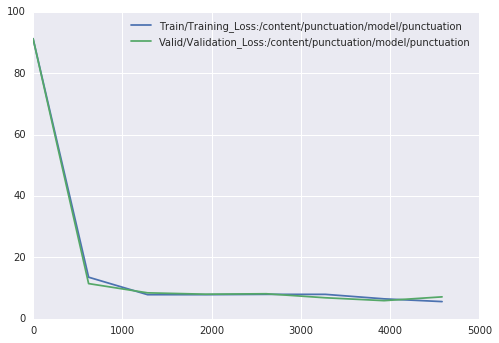

In [33]:
summary.plot(event_names=['Train/Training_Loss', 'Valid/Validation_Loss'])

From the curves above, we got the best validation results around step 4000, and then a little bit over-fitting after.

# Evaluation

At this point, we are done with training, and evaluation starts from a saved checkpoint. We will reuse the `PuctuationModel` defined earlier since evaluation model and training model are mostly the same

In [44]:
"""Run the model with some test data."""


import os

def run_eval(model_file_prefix, test_data_path):
  """Run evaluation on test data."""

  word_to_id_file = os.path.join(os.path.dirname(model_file_prefix), 'word_to_id.json')
  with open(word_to_id_file, 'r') as f:
    word_to_id = json.load(f)
  test_data_x, test_data_y = file_to_word_and_punc_ids(test_data_path, word_to_id)

  eval_config = TrainingConfig()
  eval_config.batch_size = 1
  eval_config.num_steps = 1

  with tf.Graph().as_default():
    with tf.name_scope("Test"):
      test_input = TrainingInput(config=eval_config, data_x=test_data_x, data_y=test_data_y, name="TestInput")
      with tf.variable_scope("Model", reuse=None):
        mtest = PuctuationModel(is_training=False, config=eval_config, input_=test_input)

    logdir=os.path.join(os.path.dirname(model_file_prefix), 'eval')        
    sv = tf.train.Supervisor(logdir=logdir)
    with sv.managed_session() as session:
      sv.saver.restore(session, model_file_prefix)
      test_perplexity, cm_data = run_epoch(session, mtest, 1, word_to_id, is_eval=True)
  return cm_data

View accuracy and confusion matrix.

. --- total: 941, correct: 752, accuracy: 0.799, 
, --- total: 1055, correct: 591, accuracy: 0.560, 
? --- total: 45, correct: 27, accuracy: 0.600, 
! --- total: 6, correct: 0, accuracy: 0.000, 
: --- total: 22, correct: 3, accuracy: 0.136, 
n --- total: 20725, correct: 20532, accuracy: 0.991, 
[[752, 30, 4, 0, 0, 155],
 [45, 591, 2, 0, 0, 417],
 [3, 3, 27, 0, 0, 12],
 [4, 0, 0, 0, 0, 2],
 [4, 5, 1, 0, 3, 9],
 [49, 143, 1, 0, 0, 20532]]


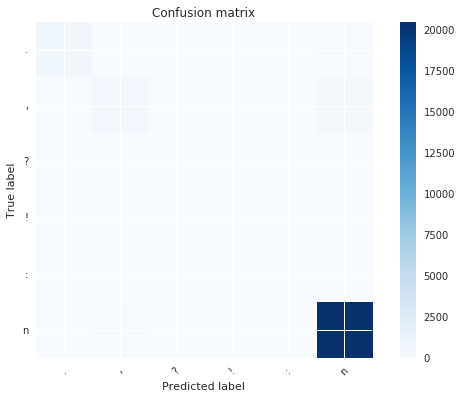

In [63]:
from google.datalab.ml import ConfusionMatrix
from pprint import pprint

cm_data = run_eval(model_file_prefix, '/content/punctuation/datapreped/test.txt')
pprint(cm_data.tolist())
cm = ConfusionMatrix(cm_data, TARGETS)
cm.plot()

Again the "no punctuation" instances are the vast majority. Some of the "," are mistakenly predicted as "no punctuation", probably because many times either with or without comma is correct in syntax. There are some confusions between "," and ".", meaning that the model "knows" it is a break in sentence, but mistakenly chose comma or period. 60% of question marks are predicted correctly, which we can give credits to LSTM model because it can "remember" the beginning of a sentence (which, what, where, etc) even if it is long.

# Prediction

Fun time. Let's try generating some puncuations on test data. First we'll define a "Prediction Model". It is a simplified Training model, with num_steps and batch_size both being 1, and no loss or training ops. But the model is "compatible" with the training model in the sense that they share same variables --- which means it can load a checkpoint produced in training.

In [65]:
import tensorflow as tf


class PredictModel(object):
  """The Prediction model."""

  def __init__(self, config):
    self._input = tf.placeholder(shape=[1, 1], dtype=tf.int64)
    size = config.hidden_size

    def lstm_cell():
      return tf.contrib.rnn.BasicLSTMCell(size, forget_bias=0.0, state_is_tuple=True)

    cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(config.num_layers)], state_is_tuple=True)
    self._initial_state = cell.zero_state(1, tf.float32)
    embedding = tf.get_variable("embedding", [VOCAB_SIZE, size], dtype=tf.float32)
    inputs = tf.nn.embedding_lookup(embedding, self._input)
    inputs = tf.unstack(inputs, num=1, axis=1)
    outputs, self._final_state = tf.contrib.rnn.static_rnn(cell, inputs, initial_state=self._initial_state)
    output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, size])
    softmax_w = tf.get_variable("softmax_w", [size, len(TARGETS)], dtype=tf.float32)
    softmax_b = tf.get_variable("softmax_b", [len(TARGETS)], dtype=tf.float32)
    logits = tf.matmul(output, softmax_w) + softmax_b
    self._prediction = tf.argmax(logits, 1)

  @property
  def input(self):
    return self._input
  
  @property
  def initial_state(self):
    return self._initial_state

  @property
  def final_state(self):
    return self._final_state
  
  @property
  def prediction(self):
    return self._prediction


In [84]:
"""The Predictor that runs the prediction model."""

import json
import os
import random


class Predictor(object):
    
  def __init__(self, model_file_prefix):
    word_to_id_file = os.path.join(os.path.dirname(model_file_prefix), 'word_to_id.json')
    with open(word_to_id_file, 'r') as f:
      self._word_to_id = json.load(f)

    config = TrainingConfig()    
    with tf.Graph().as_default():
      with tf.variable_scope("Model", reuse=None):
        self._model = PredictModel(config=config)

      saver = tf.train.Saver()
      self._session = tf.Session()
      saver.restore(self._session, model_file_prefix)

  def _get_predicted_until_punc(self, min_steps, data_x):

    state = self._session.run(self._model.initial_state)
    fetches = {
        "final_state": self._model.final_state,
        "prediction": self._model.prediction,
    }
    predicted_puncs = []
    step = 0
    for x in data_x:
      feed_dict = {}
      for i, (c, h) in enumerate(self._model.initial_state):
        feed_dict[c] = state[i].c
        feed_dict[h] = state[i].h
      feed_dict[self._model.input] = [[x]]

      vals = self._session.run(fetches, feed_dict)
      state = vals["final_state"]
      prediction = vals["prediction"]
      predicted = TARGETS[prediction[0]]
      predicted_puncs.append(predicted)
      step += 1
      if predicted != 'n' and step > min_steps:
        break
    return predicted_puncs
  
  def _apply_puncts_to_original(self, original, inserted):
    current_index = 0
    punc_positions = {}
    for w in inserted.split():
      if w in PUNCTUATIONS:
        punc_positions[current_index] = w
      else:
        current_index += 1
    words = []
    for i, w in enumerate(original.split() + ['']):
      if i in punc_positions:
        words.append(punc_positions[i])
      words.append(w)

    return ' '.join(words)
          
  def predict(self, content):
    """Insert punctuations with given string."""

    content = content.strip().lower()
    for p in PUNCTUATIONS:
      content = content.replace(' ' + p, '')
    prediction_source = content
    prediction_result = ''
    
    content = '<eos> ' + content + ' <eos>'
    min_step = 0
    while True:
      data_x = content_to_word_ids(content, self._word_to_id)
      puncts = self._get_predicted_until_punc(min_step, data_x)
      if len(data_x) == len(puncts):
        content = content.replace('. <eos> ', '').replace(' <eos>', ' ' + puncts[-1]) + '\n'
        prediction_result = self._apply_puncts_to_original(prediction_source, content)
        break
      else:
        words1 = [self._word_to_id.keys()[self._word_to_id.values().index(data_x[index])] for index in range(len(puncts) - 1)]
        indices = [i for i, w in enumerate(words1) if w in PUNCTUATIONS]
        for i in indices:
          words1[i], words1[i-1] = words1[i-1], words1[i] 
        words2 = [self._word_to_id.keys()[self._word_to_id.values().index(data_x[index])] for index in range(len(puncts) - 1, len(data_x))]
        all_words = words1 + [puncts[-1]] + words2  
        content = ' '.join(all_words)  
        min_step = len(puncts)          
    
    return prediction_source, prediction_result

  def predict_from_test_file(self, filename, num_random_lines):
    """given a file from test file, pick some random lines and do prediction."""    

    num_lines = sum(1 for line in open(filename))
    with open(filename) as f:
      lines = random.sample(f.readlines(), num_random_lines)
    for line in lines:
      line = line.strip().lower()
      source, predicted = self.predict(line)
      yield line, source, predicted

  def close(self):
    self._session.close()

Let's play with three paragraphs. First and second are single sentences, the third one contains multiple sentences.

In [71]:
predictor = Predictor(model_file_prefix)
sources = [
  'i think it is a report which will for the most part be supported by my group',
  'so what is the european union doing about it',
  'we must work more rapidly towards achieving the targets stipulated ' + 
    'in the white paper for renewable energy sources as this would bring ' + 
    'about a massive reduction in greenhouse gases but in common with others ' + 
    ' we too are having to endure the greenhouse effect furthermore we should ' + 
    'utilise an extraordinary budget line since this is an extraordinarily catastrophic situation',
]
for s in sources:
  source, predicted = predictor.predict(s)
  print('\n---SOURCE----\n' + source)
  print('---PREDICTED----\n' + predicted)

predictor.close()


---SOURCE----
i think it is a report which will for the most part be supported by my group
---PREDICTED----
i think it is a report which will , for the most part , be supported by my group . 

---SOURCE----
so what is the european union doing about it
---PREDICTED----
so what is the european union doing about it ? 

---SOURCE----
we must work more rapidly towards achieving the targets stipulated in the white paper for renewable energy sources as this would bring about a massive reduction in greenhouse gases but in common with others  we too are having to endure the greenhouse effect furthermore we should utilise an extraordinary budget line since this is an extraordinarily catastrophic situation
---PREDICTED----
we must work more rapidly towards achieving the targets stipulated in the white paper for renewable energy sources . as this would bring about a massive reduction in greenhouse gases , but in common with others , we too are having to endure the greenhouse effect . furthermore 

Try some data outside our test data (test data and training data are generated from the same data). The first two are common conversational questions, and third is from recent european parliament news.

In [86]:
predictor = Predictor(model_file_prefix)
sources = [
  'how are you',
  'where do you see yourself in five years',
  'last december the european commission proposed updating the existing customs union with ' + 
    'turkey and extending bilateral trade relations once negotiations have been completed ' + 
    'the agreement would still have to be approved by the Parliament before it could enter into force',
]
for s in sources:
  source, predicted = predictor.predict(s)
  print('\n---SOURCE----\n' + source)
  print('---PREDICTED----\n' + predicted)

predictor.close()


---SOURCE----
how are you
---PREDICTED----
how are you ? 

---SOURCE----
where do you see yourself in five years
---PREDICTED----
where do you see yourself in five years ? 

---SOURCE----
last december the european commission proposed updating the existing customs union with turkey and extending bilateral trade relations once negotiations have been completed the agreement would still have to be approved by the parliament before it could enter into force
---PREDICTED----
last december , the european commission proposed updating the existing customs union with turkey and extending bilateral trade relations once negotiations have been completed . the agreement would still have to be approved by the parliament before it could enter into force . 


The last prediction is actually somewhat incorrect. It should be:

`we must work more rapidly towards achieving the targets stipulated in the white paper for renewable energy sources , as this would bring about a massive reduction in greenhouse gases . but in common with others , we too are having to endure the greenhouse effect . furthermore , we should utilise an extraordinary budget line , since this is an extraordinarily catastrophic situation .`

It mistakenly predicted the first period where it should be comma. I think we may improve it by showing more words instead of one after the punctuation, or doing it bidirectionally and mix both scores.

As a convenience, the predictor can pick random sentences from a test files.

In [83]:
predictor = Predictor(model_file_prefix)
for t, s, p in predictor.predict_from_test_file('/content/punctuation/datapreped/test.txt', 3):
  print('\n---SOURCE----\n' + s)
  print('---PREDICTED----\n' + p)
  print('---TRUTH----\n' + t)
predictor.close()  


---SOURCE----
in view of this positive action there is every advantage to be gained from according the joint assembly a budget compatible with improving the quality of its work finally i must congratulate the council presidency on the coming europe-africa summit and call on all the participants to contribute to solid practical action to promote the development of peace democracy and the eradication of poverty in the underdeveloped countries of africa [number] today we are expressing a positive opinion on the opening of negotiations for a stabilisation and association agreement between the european union and the republic of macedonia
---PREDICTED----
in view of this positive action , there is every advantage to be gained from according the joint assembly . a budget compatible with improving the quality of its work . finally , i must congratulate the council presidency on the coming europe-africa summit and call on all the participants to contribute to solid practical action to promote 

# Clean up

In [87]:
TensorBoard.stop(tb)